## Datafiniti's Hotel Reviews Sentiment Analysis using Bag-of-words

In this demo, I'll work on the Datafiniti Hotel Reviews dataset to build a sentiment analysis model using deep learning with a bag-of-words approach.

This dataset contains reviews with a title, a content and a rating. It also cointains information about the hotel and the reviewer, but I'll keep it simple by now and I'll only use the review title to predict the review rating. I'll then pass a title to this model to predict whether it's a good or a bad review.

In [1]:
import pandas as pd

hotels = pd.read_csv('data/Datafiniti_Hotel_Reviews.csv')
hotels = hotels.loc[:, ['reviews.rating', 'reviews.title']]
hotels.reset_index(inplace=True)
hotels['reviews.title'] = hotels['reviews.title'].apply(lambda x: str(x))
hotels.head()

,index,reviews.rating,reviews.title
0,0,5.0,Best romantic vacation ever!!!!
1,1,5.0,Sweet sweet serenity
2,2,5.0,Amazing Property and Experience
3,3,2.0,"Never again...beware, if you want sleep."
4,4,5.0,ALWAYS GREAT STAY...


### Training and test sets

In [2]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(hotels)

#### Data preprocessing

We'll use keras `Tokenizer` class to perform some preprocessing on the text:

1. Lowercase
2. Remove puntuation
3. Tokenize
4. Transform text into index vectors

I'll use maximum 500 words

In [24]:
import pickle
from keras.preprocessing.text import Tokenizer

MAX_WORDS = 500
tokenizer = Tokenizer(num_words=MAX_WORDS)

X_train = train_set.loc[:, 'reviews.title'].values
y_train = train_set['reviews.rating']

X_test = test_set.loc[:, 'reviews.title'].values
y_test = test_set['reviews.rating']

tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)

with open('datafiniti_hotel_reviews_sentiment_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Model

### Network Architecture

In [8]:
import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential


model = Sequential()

model.add(Dense(units=1024, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=1024, activation='relu', input_dim=1024))
model.add(Dropout(0.2))
model.add(Dense(units=512, activation='relu', input_dim=1024))
model.add(Dropout(0.2))
model.add(Dense(units=1, input_dim=512))

model.compile(loss='mse',
              optimizer='adam', 
              metrics=['mae'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              513024    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total para

### Model training

As the data is not that big and I'll be using a GPU, I'll use the full data on each epoch. Also, I'll split use 20% of the data as validation set to monitor if there's overfitting.

#### TensorBoard

To monitor the model's improvement over the epochs, I'll use the TensorBoard callback. For this, I'll have to create a log directory to store TensorFlow logs that TensorBoard will use to show the plots.

In [ ]:
!mkdir my_log_dir

#### Callbacks and model fit

In [15]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_mean_absolute_error', patience=50),
    ModelCheckpoint(filepath='datafiniti_hotel_reviews_sentiment.h5', monitor='val_loss', save_best_only=True),
    TensorBoard(log_dir='my_log_dir', histogram_freq=1)
]

model.reset_states()
history = model.fit(X_train, y_train, epochs=500, batch_size=len(X_train), verbose=0, validation_split=0.2, callbacks=callbacks)

#### Plot model history

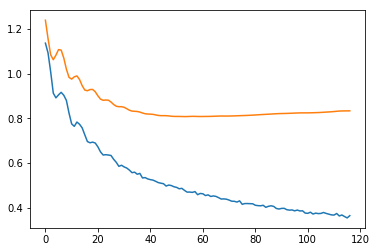

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

val_loss = history.history['val_loss']
loss = history.history['loss']

epochs = np.arange(len(loss))
up_to_epoch = 500

plt.plot(loss)
plt.plot(val_loss)
plt.show()

### Predictions

In [18]:
def predict_rating(text, model):
    text_vector = tokenizer.texts_to_matrix([text])
    prediction = model.predict(text_vector)
    
    return prediction[0, 0]

In [22]:
from keras.models import load_model
loaded_model = load_model("datafiniti_hotel_reviews_sentiment.h5")

title = 'this hotel was a great experience in my life'
print(title, predict_rating(title, loaded_model))

title = 'awful experience'
print(title, predict_rating(title, loaded_model))

title = 'service was disappointing'
print(title, predict_rating(title, loaded_model))

title = 'totally recommended'
print(title, predict_rating(title, loaded_model))

this hotel was a great experience in my life 3.746072
awful experience 1.6366513
service was disappointing 2.4090168
totally recommended 4.762338


### Possible Improvements

This model can improve if we apply some other techniques. To name some: 

- Word embeddings to preserve the words meaning
- Word stemming
- N-grams or even convolutional neural networks to preserve the meaning of consecutive words
- Recurrent neural networks to use the fact that sentences are sequences
